In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def chinese2english(df):
    columnsDict = {
        'Length': '长度',
        'Geographic Region': '地理区域',
        'Country ': '国家',
        'Listing Price': '售价',
        'Year': '年份',
        'Make Variant': '名称',
        'LWL': '水线长度',
        'Beam': '宽度',
        'Draft': '吃水',
        'Displacement': '排水',
        'Sail Area': '帆面积',
        'AVG Cargo Thro.': '平均货物吞吐量',
        'GDP': 'GDP',
        'GDP per capita': '人均GDP',
        'Average proportion of total logistics cost to GDP': '物流总成本占GDP的平均比例',
        'Hull Type': '类型',
    }
    print({v: k for k, v in columnsDict.items()})
    df.rename(columns={v: k for k, v in columnsDict.items()}, inplace=True)
    return df

In [23]:
def processXlsx(sheetName):
    '''
    拼接xlsx
    :param sheetName:
    :return:
    '''
    print(f'-------开始:{sheetName}-------')
    mData0 = pd.read_excel('../../2023_MCM_Problem_Y_Boats.xlsx', sheet_name=f'{sheetName}')
    mData1 = pd.read_excel('../../2023_MCM_Problem_Y_Boats.xlsx', sheet_name=f'{sheetName}_1')
    mData2 = pd.read_excel('../../2023_MCM_Problem_Y_Boats.xlsx', sheet_name=f'{sheetName}_2')
    mData0.count()

    # 未知值修改为NaN
    for i in ['平均货物吞吐量（吨）', 'GDP（亿美元）', '人均GDP（美元）', '物流总成本占GDP的平均比例']:
        mData2[i] = mData2[i].apply(lambda x: np.NaN if x == '-' else x)

    # 统一厂家型号到一个字段

    def getMakeModel(x):
        return str(x['Make']) + ' ' + str(x['Variant'])

    mData0['Make Variant'] = mData0.apply(lambda x: getMakeModel(x), axis=1)
    mData0.head()

    # 合并原表和帆船参数表
    mData1['型号'] = mData1['型号'].apply(lambda x: x.replace(' ', ''))
    mData0['Make Variant'] = mData0['Make Variant'].apply(lambda x: x.replace(' ', ''))
    mData1.drop_duplicates(keep='first', subset='型号', inplace=True)
    mData = pd.merge(mData0, mData1, how='left', left_on='Make Variant', right_on='型号')
    mData.drop(columns=['Make', 'Variant', '型号'], inplace=True)
    mData.head()

    # 合并地区表
    def x2lower(x):
        try:
            return x.lower().replace(' ', '')
        except:
            return x

    mData2['城市/地区'] = mData2['城市/地区'].apply(lambda x: x2lower(x))
    mData['Country/Region/State '] = mData['Country/Region/State '].apply(lambda x: x2lower(x))
    mData = pd.merge(mData, mData2, how='left', left_on='Country/Region/State ', right_on='城市/地区')
    mData.drop(columns=['城市/地区'], inplace=True)

    print(f'-------结束:{sheetName}-------')
    return mData

In [24]:
def preprocess(mData, tag):
    '''
    预处理函数
    :param mData:
    :param tag:
    :return:
    '''

    print(f'-------开始:{tag}-------')
    '''
    数据预处理开始
    -----------1. 去除空值-------------
    '''
    mData.dropna(inplace=True)
    mData.reset_index(inplace=True, drop=True)
    # mData.shape

    # 修正列名
    columnsDict = {
        'Make': '制造商',
        'Variant': '型号',
        'Length \n(ft)': '长度',
        'Geographic Region': '地理区域',
        'Country/Region/State ': '国家',
        'Listing Price (USD)': '售价',
        'Year': '年份',
        'Make Variant': '名称',
        'LWL (ft)': '水线长度',
        'Beam (ft)': '宽度',
        'Draft (ft)': '吃水',
        'Displacement (lbs)': '排水',
        'Sail Area (sq ft)': '帆面积',
        '平均货物吞吐量（吨）': '平均货物吞吐量',
        'GDP（亿美元）': 'GDP',
        '人均GDP（美元）': '人均GDP',
        '物流总成本占GDP的平均比例': '物流总成本占GDP的平均比例'
    }
    mData.rename(columns=columnsDict, inplace=True)

    ''''
    新的列名
    '''
    listingPrice = '售价'
    draft = '吃水'
    displacement = '排水'
    sailAria = '帆面积'
    averageCargoThroughput = '平均货物吞吐量'
    gdpPerCapita = '人均GDP'
    year = '年份'

    # mData

    '''
    ---------------2. 3sigma处理异常值-----------------
    '''
    print('原始数据数据', mData.shape)

    ## 可视化探索价格的分布情况
    sns.displot(data=chinese2english(mData.copy()), x="Listing Price",height = 6,aspect=1.5)
    plt.savefig(f'未3sigma的Listing Price-{tag}.svg')
    plt.show()

    # 计算均值和标准差
    mean = mData[listingPrice].mean()
    std = mData[listingPrice].std()

    # 根据 3 Sigma 原则，将数据分为正常值和异常值
    mData = mData[(mData[listingPrice] > mean - 3 * std) & (mData[listingPrice] < mean + 3 * std)]

    ## 可视化数据对数变换后的数据
    sns.displot(data=chinese2english(mData.copy()), x="Listing Price",height = 6,aspect=1.5)
    plt.savefig(f'3sigma后的Listing Price-{tag}.svg')
    plt.show()

    # 输出清除异常值后的数据
    print('清除异常值后的数据', mData.shape)

    noEncodeMData = mData.copy()


    '''
    ---------------3. 对定性数据进行标签编码-----------------
    '''
    from sklearn.preprocessing import LabelEncoder
    needEncode = [
        '地理区域',
        '国家',
        '名称',
    ]

    # 创建 LabelEncoder 对象
    le = LabelEncoder()

    for lab in needEncode:
        mData[lab] = le.fit_transform(mData[lab])

    '''
    -------------4. 特征缩放---------------
    '''
    mData[year] = mData[year].astype('int64')

    mData[listingPrice] = np.log(mData[listingPrice])
    mData[averageCargoThroughput] = np.log(mData[averageCargoThroughput])
    mData[gdpPerCapita] = np.log(mData[gdpPerCapita])
    mData[displacement] = np.log(mData[displacement])
    mData[sailAria] = mData[sailAria] / 10
    mData[year] = mData[year] - mData[year].min()

    print(f'-------结束:{tag}-------')
    return noEncodeMData, mData

    # mData.to_excel(xlsxWriter, index=False, sheet_name=f'缩放{sheetName}')
    # xlsxWriter.save()


-------开始:Monohulled Sailboats-------
-------结束:Monohulled Sailboats-------
-------开始:preprocess[Monohulled Sailboats]-------
原始数据数据 (2098, 15)
{'长度': 'Length', '地理区域': 'Geographic Region', '国家': 'Country ', '售价': 'Listing Price', '年份': 'Year', '名称': 'Make Variant', '水线长度': 'LWL', '宽度': 'Beam', '吃水': 'Draft', '排水': 'Displacement', '帆面积': 'Sail Area', '平均货物吞吐量': 'AVG Cargo Thro.', 'GDP': 'GDP', '人均GDP': 'GDP per capita', '物流总成本占GDP的平均比例': 'Average proportion of total logistics cost to GDP', '类型': 'Hull Type'}


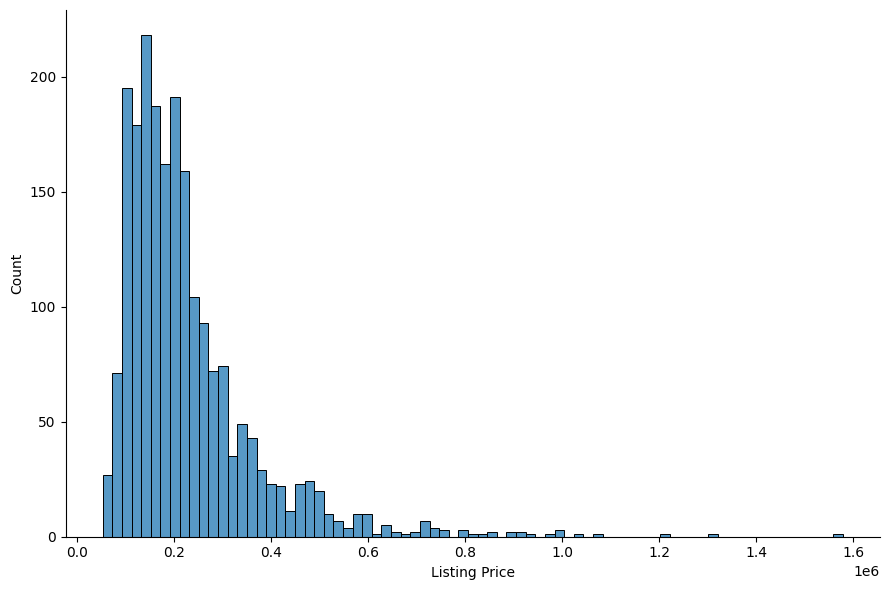

{'长度': 'Length', '地理区域': 'Geographic Region', '国家': 'Country ', '售价': 'Listing Price', '年份': 'Year', '名称': 'Make Variant', '水线长度': 'LWL', '宽度': 'Beam', '吃水': 'Draft', '排水': 'Displacement', '帆面积': 'Sail Area', '平均货物吞吐量': 'AVG Cargo Thro.', 'GDP': 'GDP', '人均GDP': 'GDP per capita', '物流总成本占GDP的平均比例': 'Average proportion of total logistics cost to GDP', '类型': 'Hull Type'}


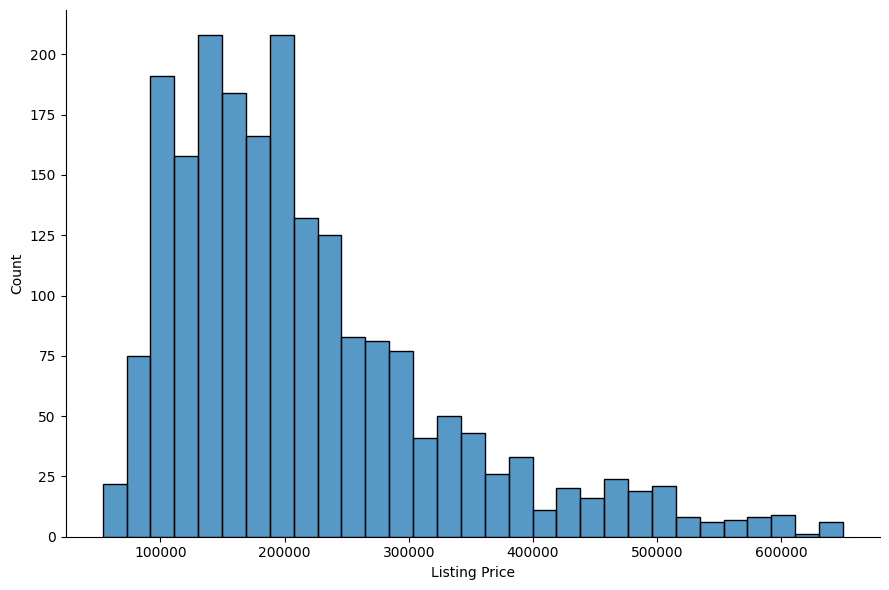

清除异常值后的数据 (2059, 15)
-------结束:preprocess[Monohulled Sailboats]-------
-------开始:Catamarans-------


D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mData[lab] = le.fit_transform(mData[lab])
D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mData[lab] = le.fit_transform(mData[lab])
D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

-------结束:Catamarans-------
-------开始:preprocess[Catamarans]-------
原始数据数据 (918, 15)
{'长度': 'Length', '地理区域': 'Geographic Region', '国家': 'Country ', '售价': 'Listing Price', '年份': 'Year', '名称': 'Make Variant', '水线长度': 'LWL', '宽度': 'Beam', '吃水': 'Draft', '排水': 'Displacement', '帆面积': 'Sail Area', '平均货物吞吐量': 'AVG Cargo Thro.', 'GDP': 'GDP', '人均GDP': 'GDP per capita', '物流总成本占GDP的平均比例': 'Average proportion of total logistics cost to GDP', '类型': 'Hull Type'}


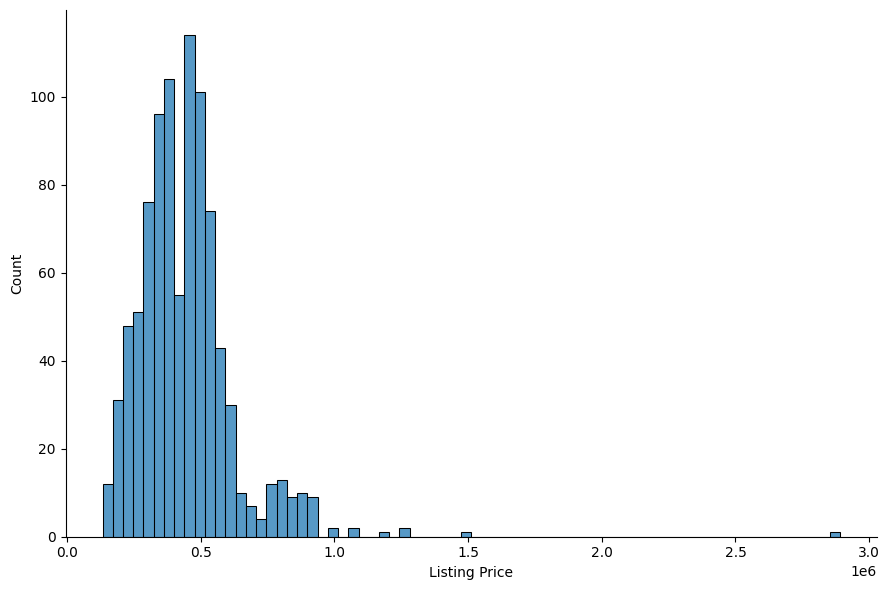

{'长度': 'Length', '地理区域': 'Geographic Region', '国家': 'Country ', '售价': 'Listing Price', '年份': 'Year', '名称': 'Make Variant', '水线长度': 'LWL', '宽度': 'Beam', '吃水': 'Draft', '排水': 'Displacement', '帆面积': 'Sail Area', '平均货物吞吐量': 'AVG Cargo Thro.', 'GDP': 'GDP', '人均GDP': 'GDP per capita', '物流总成本占GDP的平均比例': 'Average proportion of total logistics cost to GDP', '类型': 'Hull Type'}


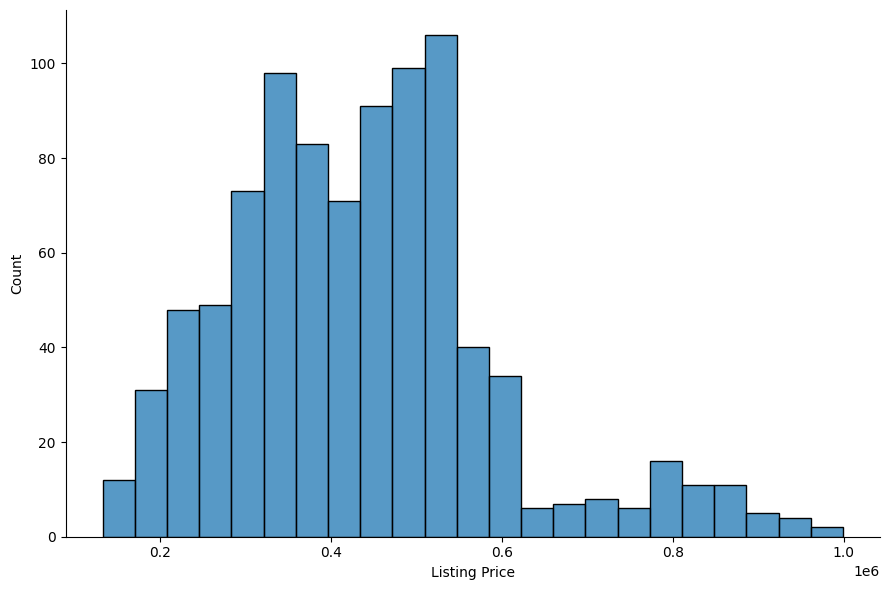

清除异常值后的数据 (911, 15)
-------结束:preprocess[Catamarans]-------


D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mData[lab] = le.fit_transform(mData[lab])
D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mData[lab] = le.fit_transform(mData[lab])
D:\Users\win\AppData\Local\Temp\ipykernel_37592\727585109.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

success


In [25]:
sheetNameList = [
    'Monohulled Sailboats',
    'Catamarans',
]
dataDict = {

}
encodeDataDict = {}
noEncodeDataDict = {}

for sheetName in sheetNameList:
    # 拼接三表之后的数据
    rawData = processXlsx(sheetName)
    # 数据预处理
    noEncodeData, data = preprocess(rawData, f'preprocess[{sheetName}]')
    dataDict[f'未编码{sheetName}'] = noEncodeData.copy()
    dataDict[f'已编码{sheetName}'] = data.copy()
    noEncodeDataDict[sheetName] = noEncodeData.copy()
    encodeDataDict[sheetName] = data.copy()

xlsxWriter = pd.ExcelWriter(f'./xlsx/合并修正缩放后总数据.xlsx')
for k, data in dataDict.items():
    data.to_excel(xlsxWriter, index=False, sheet_name=k)


def combind(dataDict, sheetName, typeCol='类型'):
    combindDf = pd.DataFrame()
    for idx, key in enumerate(dataDict.keys()):
        data = dataDict[key].copy()
        data[typeCol] = idx
        # 合并两个 DataFrame
        combindDf = pd.concat([combindDf, data])

    # 将合并后的数据保存到新的 Excel 文件
    combindDf.to_excel(xlsxWriter, sheet_name=sheetName, index=False)


'''
未编码汇总
已编码汇总
'''
combind(encodeDataDict, '已编码汇总')
combind(noEncodeDataDict, '未编码汇总')

xlsxWriter.save()
print('success')

In [26]:
noEncodeDataDict['Catamarans']

,长度,地理区域,国家,售价,年份,名称,水线长度,宽度,吃水,排水,帆面积,平均货物吞吐量,GDP,人均GDP,物流总成本占GDP的平均比例
0,38.0,USA,florida,219000,2005,Lagoon380,37.92,21.50,3.75,16093.0,753,240000000.0,1000.0,47682,9.5
1,39.0,Caribbean,mexico,210000,2005,FountainePajotLavezzi40,38.67,21.08,3.67,19800.0,958,270000000.0,1150.0,9293,12.8
2,39.0,Caribbean,panama,200000,2005,Leopard40,38.08,22.08,4.08,22046.0,1033,76000000.0,66.8,16466,13.2
3,39.5,Europe,croatia,188252,2005,Nautitech40,39.33,22.08,4.17,19621.0,1087,595000.0,57.8,13647,9.4
4,39.5,Europe,croatia,188252,2005,Nautitech40,39.33,22.08,4.17,19621.0,1087,595000.0,57.8,13647,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,48.0,Europe,greece,849625,2019,Lagoon50,48.42,26.08,4.25,52359.0,1668,10780000.0,209.0,18694,13.8
912,48.0,Europe,greece,789584,2019,Lagoon50,48.42,26.08,4.25,52359.0,1668,10780000.0,209.0,18694,13.8
913,48.0,Europe,greece,788937,2019,Lagoon50,48.42,26.08,4.25,52359.0,1668,10780000.0,209.0,18694,13.8
914,48.0,Europe,greece,788937,2019,Lagoon50,48.42,26.08,4.25,52359.0,1668,10780000.0,209.0,18694,13.8
